In [6]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ESTRUTURA PROPOSTA:


###    1. Introdução

###    2. Project Understanding

###    3. Data Understanding
#####  3.1. Descrição
#####  3.2. EDA
#####  3.3. Correlações
#####  3.4. Qualidade dos dados

###    4. Data Preparation
#####  4.1. Limpeza
#####  4.2. Transformações
#####  4.3. Feature Engineering

###    5. Modeling
#####  5.1. Clustering
#####  5.2. Modelos de previsão
#####  5.3. Normalização

###    6. Evaluation

###    7. Conclusion

###    8. References

# 3. Data Understanding
 
O dataset utilizado corresponde ao registo contínuo de consumos energéticos de vários edifícios municipais da Maia, recolhidos através de sistemas de telemetria. As medições são efetuadas em intervalos regulares de 15 minutos, permitindo caracterizar com grande detalhe os padrões de utilização energética ao longo do tempo.
 ## 3.1 Descrição do Dataset
Cada registo do Dataset, incluí:
 - Código do local (CPE);
 - Timestamp da medição (tstamp);
 - DadosDeConsumo (kW/h);
 - Potência Ativa (kW/h);
 - Potência Reativa Indutiva (VAR);
 - Potência Reativa Capacitiva (VAR).



In [7]:
df = pl.read_csv(
    "consumo15m_11_2025.csv",
    null_values="NULL"
)

df

CPE,tstamp,DadosdeConsumo,PotActiva,PotReactIndut,PotReactCapac
str,str,str,f64,str,str
"""PT0002000089069203YG""","""2022-12-31 00:15:00""",null,0.296,null,null
"""PT0002000089069203YG""","""2022-12-31 00:30:00""",null,0.292,null,null
"""PT0002000089069203YG""","""2022-12-31 00:45:00""",null,0.284,null,null
"""PT0002000089069203YG""","""2022-12-31 01:00:00""",null,0.28,null,null
"""PT0002000089069203YG""","""2022-12-31 01:15:00""",null,0.272,null,null
…,…,…,…,…,…
"""PT0002000110607652SB""","""2025-04-30 23:00:00""",null,3.0,"""1.000""","""0.000"""
"""PT0002000110607652SB""","""2025-04-30 23:15:00""",null,3.0,"""2.000""","""0.000"""
"""PT0002000110607652SB""","""2025-04-30 23:30:00""",null,3.0,"""1.000""","""0.000"""



# 3.2 Limpeza Inicial e Conversão de Tipos
 Antes de proceder à análise, é essencial garantir:
 - conversão do timestamp para formato datetime;
 - conversão das colunas numéricas para float;
 - eliminação/tratamento dos valores "NULL".
 
Estas etapas são fundamentais, pois garantem a consistência do dataset e permitem realizar operações estatísticas e temporais de forma correta. Após esta limpeza, os dados ficam prontos para uma exploração detalhada e fiável.

In [8]:
df = df.with_columns(
    pl.col("tstamp").str.to_datetime("%Y-%m-%d %H:%M:%S")
)

df = df.with_columns([
    pl.col("DadosdeConsumo").cast(pl.Float64),
    pl.col("PotReactIndut").cast(pl.Float64),
    pl.col("PotReactCapac").cast(pl.Float64),
])

df.dtypes

[String,
 Datetime(time_unit='us', time_zone=None),
 Float64,
 Float64,
 Float64,
 Float64]

# 3.3 Análise Descritiva e Visualização

Nesta fase, são calculadas as principais métricas estatísticas, como média, desvio padrão, valores mínimos e máximos. Esta análise, complementada por histogramas, permite uma compreensão inicial da distribuição e da escala das variáveis, sendo fundamental para detetar anomalias, como outliers ou valores inesperados.

In [9]:
df.describe().transpose(include_header=True, header_name="statistic", column_names="statistic")

statistic,count,null_count,mean,std,min,25%,50%,75%,max
str,str,str,str,str,str,str,str,str,str
"""CPE""","""5940182""","""0""",null,null,"""PT0002000032936306KX""",null,null,null,"""PT0002000201936109ME"""
"""tstamp""","""5940182""","""0""","""2024-04-15 22:32:26.636113""",null,"""2022-12-31 00:15:00""","""2023-09-28 05:00:00""","""2024-05-15 14:00:00""","""2024-11-08 01:00:00""","""2025-05-01 00:00:00"""
"""DadosdeConsumo""","""0.0""","""5940182.0""",null,null,null,null,null,null,null
"""PotActiva""","""5940182.0""","""0.0""","""8.093966159622719""","""23.018326816845473""","""0.0""","""0.12""","""2.0""","""7.0""","""574.0"""
"""PotReactIndut""","""3668710.0""","""2271472.0""","""1.7153228246440848""","""3.385570409509408""","""0.0""","""0.0""","""0.0""","""2.0""","""177.0"""
"""PotReactCapac""","""3668710.0""","""2271472.0""","""0.6525601641994052""","""1.6623693221226727""","""0.0""","""0.0""","""0.0""","""1.0""","""124.0"""


In [10]:
df.select(pl.col("CPE").n_unique())

CPE
u32
91


O conjunto de dados contém 91 CPEs distintos.

In [11]:
# missing por coluna
df.null_count()

CPE,tstamp,DadosdeConsumo,PotActiva,PotReactIndut,PotReactCapac
u32,u32,u32,u32,u32,u32
0,0,5940182,0,2271472,2271472


In [12]:
# percentagem de zeros na PotActiva
total = df.height
zeros = df.filter(pl.col("PotActiva") == 0).height
print(f"Percentagem de PotActiva = 0: {zeros / total * 100} %")

Percentagem de PotActiva = 0: 14.897220320858857 %


A análise inicial revelou que a variável DadosdeConsumo se encontra totalmente nula, pelo que não será útil na modelação inicial. Verificou-se ainda que cerca de 15% dos valores de PotActiva são zero, o que indica longos períodos de baixa atividade energética. Também é possivel reparar na falta de valores de potência reativa indutiva e condutiva para ~~certas secções das séries temporais~~ criando buracos na informação

## Outlier

## Análise de Histogramas


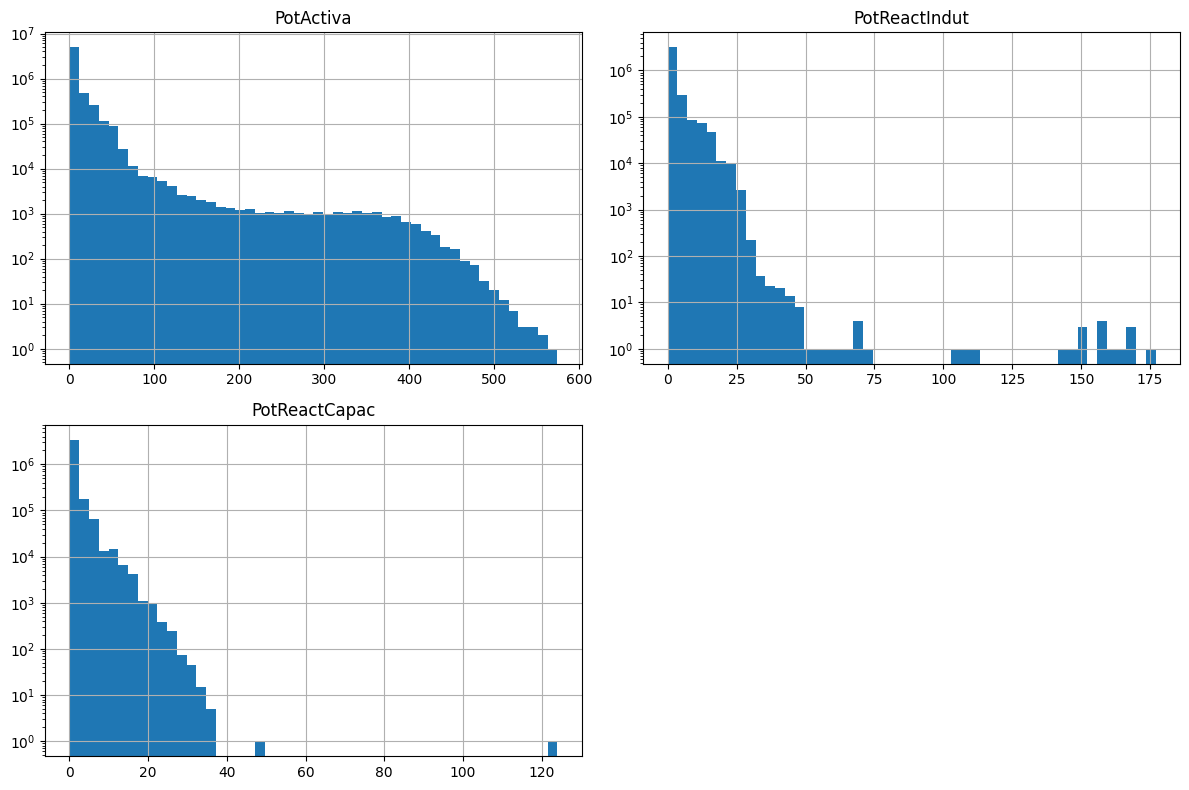

In [54]:
histo = df.select([
    "PotActiva",
    "PotReactIndut",
    "PotReactCapac"
]).to_pandas()

histo.hist(bins=50, figsize=(12,8), log=True)
plt.tight_layout()
plt.show()

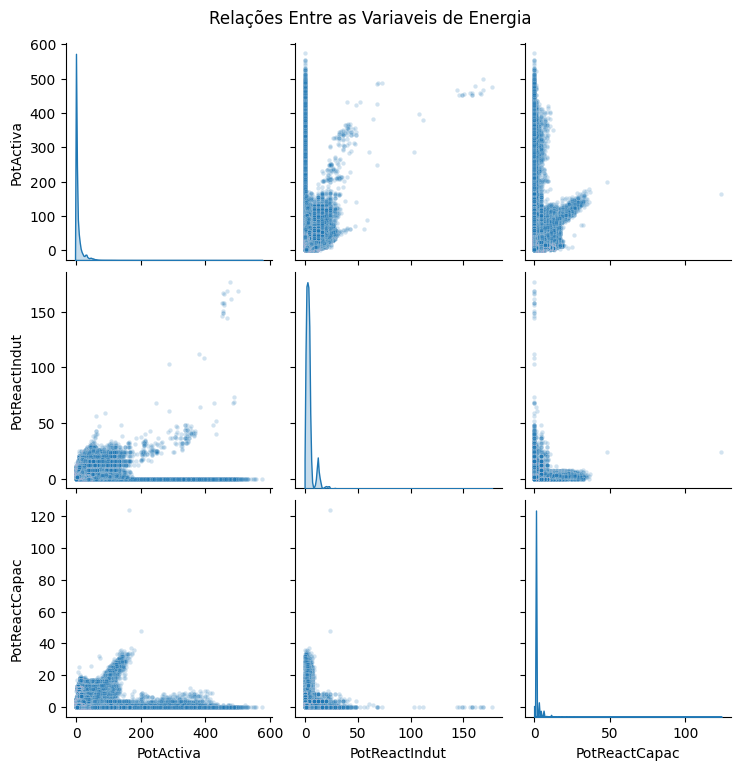

In [14]:
sns.pairplot(
    histo,
    diag_kind="kde",
    plot_kws={"alpha": 0.2, "s": 10} 
)
plt.suptitle("Relações Entre as Variaveis de Energia", y=1.02)
plt.show()

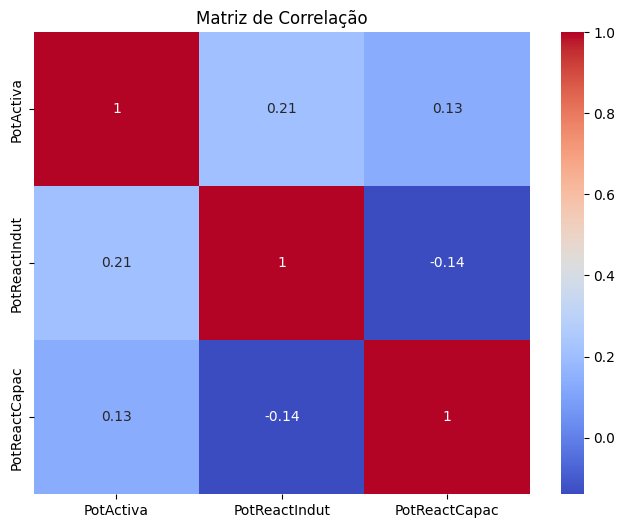

In [15]:
plt.figure(figsize=(8,6))
sns.heatmap(histo.corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de Correlação")
plt.show()

A matriz de correlação mostra que as três variáveis energéticas analisadas têm uma relação fraca entre si. A potência ativa apresenta apenas uma correlação ligeiramente positiva com a potência reativa indutiva (0.21) e uma ainda mais baixa com a componente capacitiva (0.13). Isto significa que, mesmo quando a potência ativa aumenta, as componentes reativas nem sempre acompanham esse aumento de forma clara ou consistente. Também se observa uma correlação fraca e negativa entre a potência reativa indutiva e capacitiva (-0.14).
No geral, estes valores mostram que as variáveis não são redundantes e captam dimensões distintas do comportamento elétrico dos edifícios, o que as torna úteis para as fases seguintes de preparação e modelação dos dados.

## Análise Temporal
Como o dataset inclui timestamps, é útil analisar o comportamento das variáveis ao longo do tempo permitindo:
<p>-identificar padrões diários e semanais;<p>
-ajudar a perceber períodos de maior e menor atividade; <p>
-facilitar a deteção de picos, anomalias e variações sazonais;



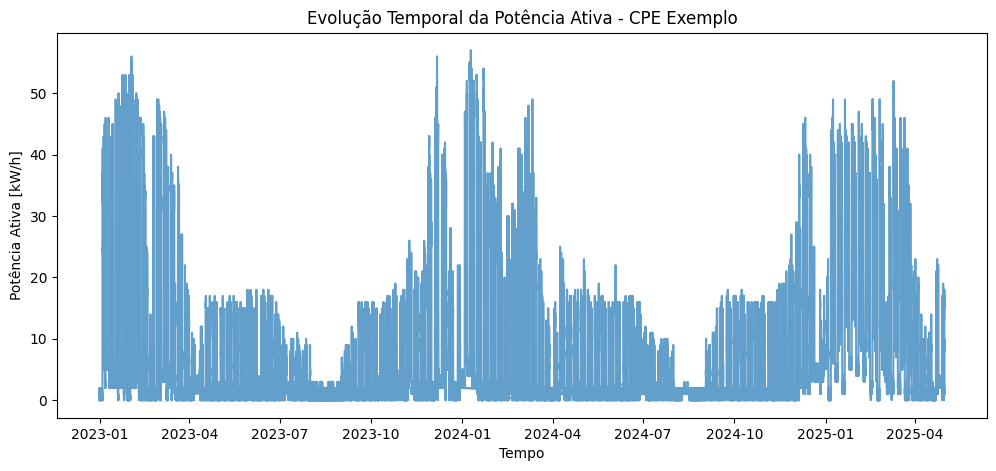

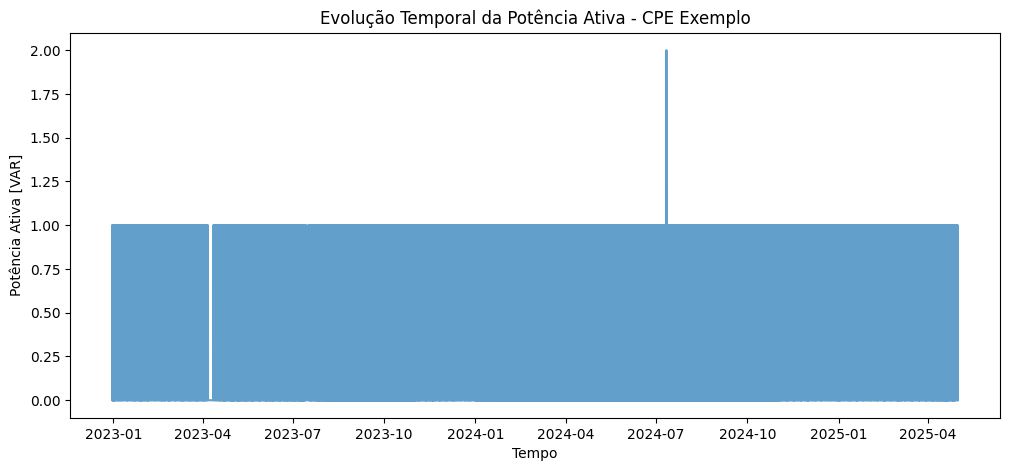

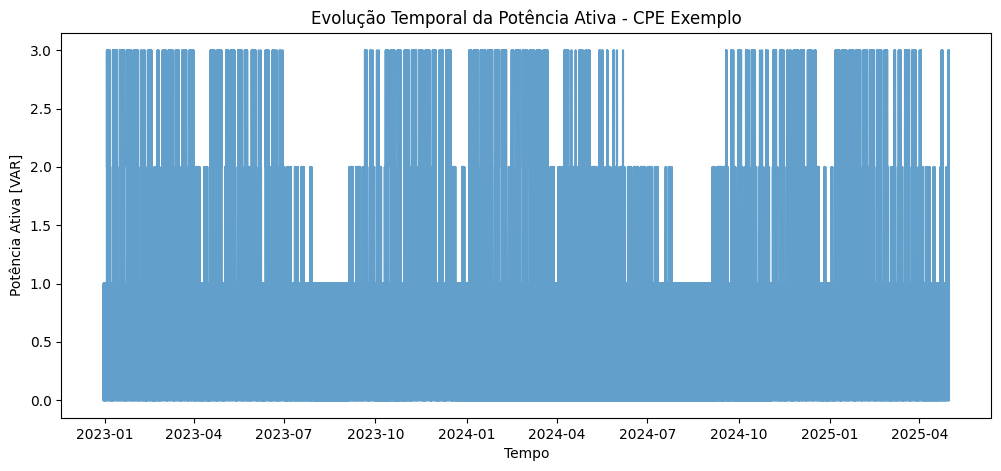

In [16]:
sample_cpe = df.filter(pl.col("CPE") == df["CPE"][1000000])  # escolher 1 edificio
pdf = sample_cpe.to_pandas()

plt.figure(figsize=(12,5))
plt.plot(pdf["tstamp"], pdf["PotActiva"], alpha=0.7)
plt.title("Evolução Temporal da Potência Ativa - CPE Exemplo")
plt.xlabel("Tempo")
plt.ylabel("Potência Ativa [kW/h]")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(pdf["tstamp"], pdf["PotReactIndut"], alpha=0.7)
plt.title("Evolução Temporal da Potência Ativa - CPE Exemplo")
plt.xlabel("Tempo")
plt.ylabel("Potência Ativa [VAR]")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(pdf["tstamp"], pdf["PotReactCapac"], alpha=0.7)
plt.title("Evolução Temporal da Potência Ativa - CPE Exemplo")
plt.xlabel("Tempo")
plt.ylabel("Potência Ativa [VAR]")
plt.show()

### Perfis Diários, semanais e mensais

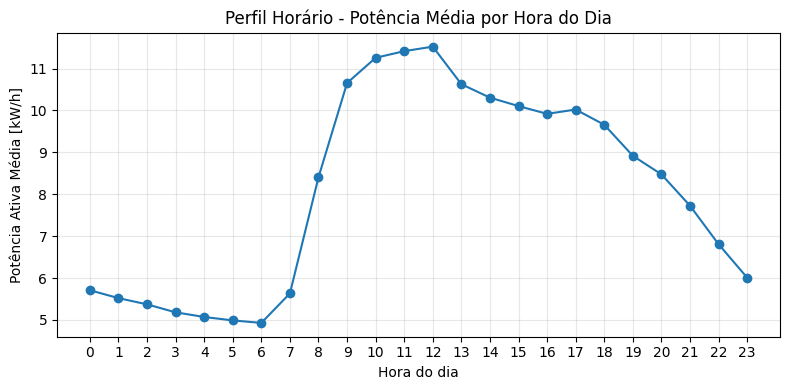

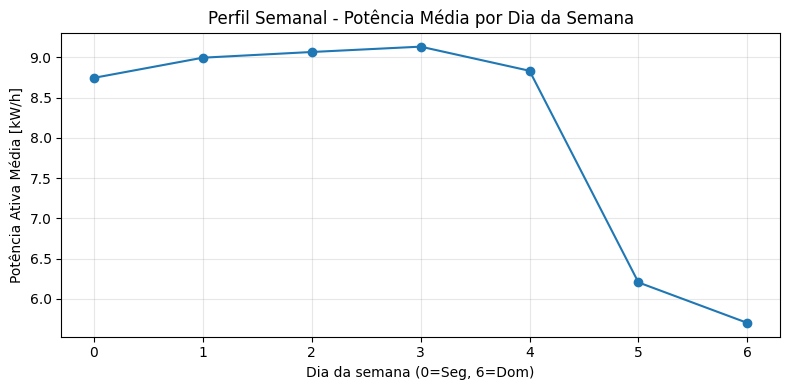

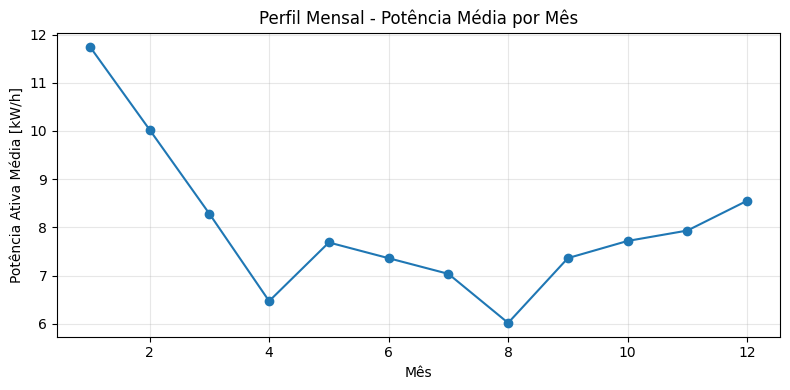

In [17]:
# Perfil Diário
pdf = df.to_pandas()
pdf["hour"] = pdf["tstamp"].dt.hour

hourly = pdf.groupby("hour")["PotActiva"].mean().reset_index()

plt.figure(figsize=(8,4))
plt.plot(hourly["hour"], hourly["PotActiva"], marker="o")
plt.xlabel("Hora do dia")
plt.ylabel("Potência Ativa Média [kW/h]")
plt.title("Perfil Horário - Potência Média por Hora do Dia")
plt.xticks(range(0,24))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Perfil Semanal
pdf["weekday"] = pdf["tstamp"].dt.weekday  

weekly = pdf.groupby("weekday")["PotActiva"].mean().reset_index()

plt.figure(figsize=(8,4))
plt.plot(weekly["weekday"], weekly["PotActiva"], marker="o")
plt.xlabel("Dia da semana (0=Seg, 6=Dom)")
plt.ylabel("Potência Ativa Média [kW/h]")
plt.title("Perfil Semanal - Potência Média por Dia da Semana")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Perfil Mensal
pdf["month"] = pdf["tstamp"].dt.month

monthly = pdf.groupby("month")["PotActiva"].mean().reset_index()

plt.figure(figsize=(8,4))
plt.plot(monthly["month"], monthly["PotActiva"], marker="o")
plt.xlabel("Mês")
plt.ylabel("Potência Ativa Média [kW/h]")
plt.title("Perfil Mensal - Potência Média por Mês")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



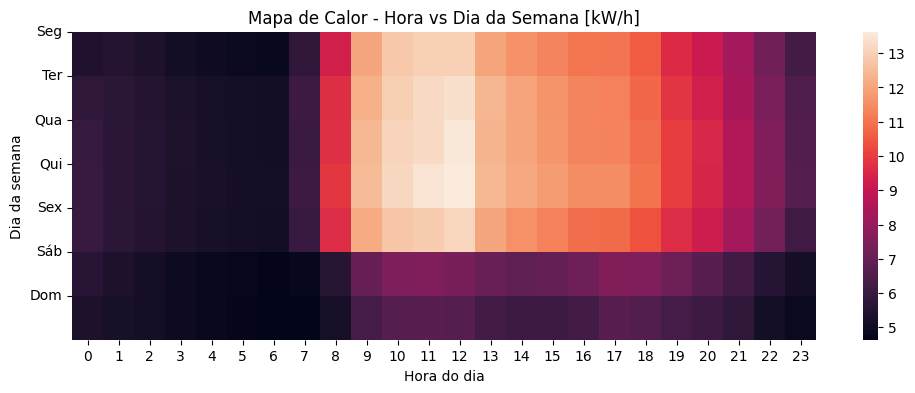

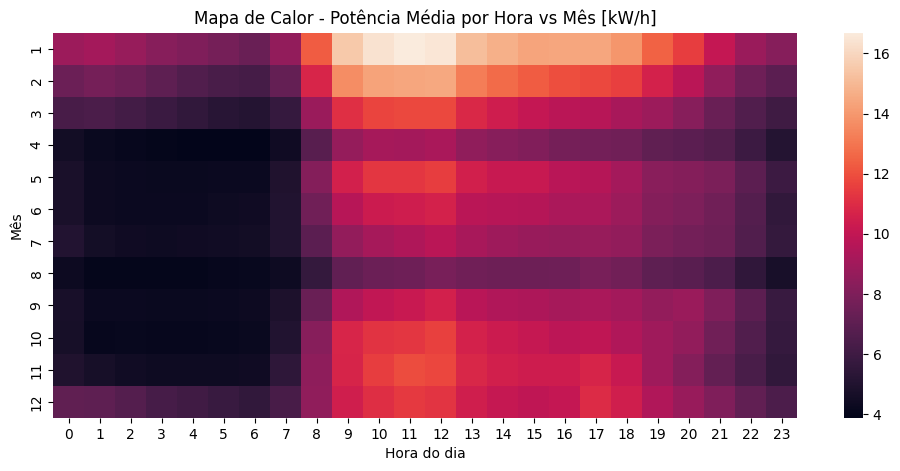

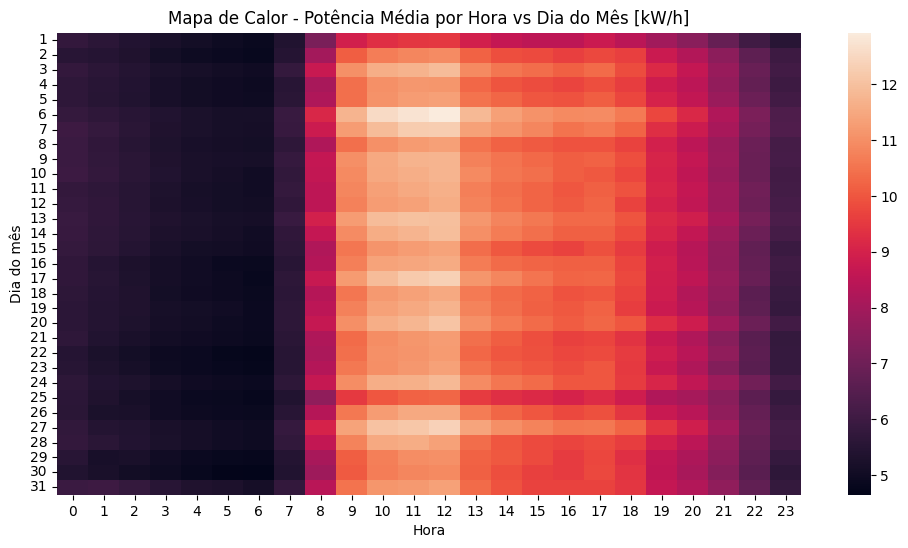

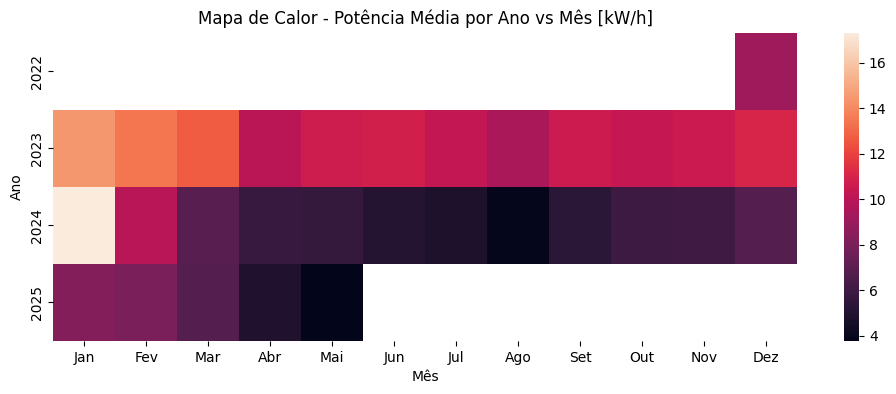

In [18]:

pdf["year"] = pdf["tstamp"].dt.year
pdf["month"] = pdf["tstamp"].dt.month
pdf["weekday"] = pdf["tstamp"].dt.weekday
pdf["hour"] = pdf["tstamp"].dt.hour
pdf["day"] = pdf["tstamp"].dt.day
pivot = pdf.pivot_table(
    values="PotActiva",
    index="weekday",
    columns="hour",
    aggfunc="mean"
)

plt.figure(figsize=(12,4))
sns.heatmap(pivot, cmap="rocket")

# Títulos
plt.title("Mapa de Calor - Hora vs Dia da Semana [kW/h]")
plt.xlabel("Hora do dia")
plt.ylabel("Dia da semana")

# Substituir 0..6 pelos nomes
dias = ["Seg", "Ter", "Qua", "Qui", "Sex", "Sáb", "Dom"]
plt.yticks(ticks=range(7), labels=dias, rotation=0)

pivot_month_hour = pdf.pivot_table(
    values="PotActiva",
    index="month",
    columns="hour",
    aggfunc="mean"
)

plt.figure(figsize=(12,5))
sns.heatmap(pivot_month_hour, cmap="rocket")
plt.title("Mapa de Calor - Potência Média por Hora vs Mês [kW/h]")
plt.xlabel("Hora do dia")
plt.ylabel("Mês")
plt.show()


pivot_day_hour = pdf.pivot_table(
    values="PotActiva",
    index="day",
    columns="hour",
    aggfunc="mean"
)

plt.figure(figsize=(12,6))
sns.heatmap(pivot_day_hour, cmap="rocket")
plt.title("Mapa de Calor - Potência Média por Hora vs Dia do Mês [kW/h]")
plt.xlabel("Hora")
plt.ylabel("Dia do mês")
plt.show()



pivot_year_month = pdf.pivot_table(
    values="PotActiva",
    index="year",
    columns="month",
    aggfunc="mean"
)
meses = ["Jan", "Fev", "Mar", "Abr", "Mai", "Jun",
         "Jul", "Ago", "Set", "Out", "Nov", "Dez"]

plt.figure(figsize=(12,4))
sns.heatmap(pivot_year_month, cmap="rocket", 
            xticklabels=meses)
plt.title("Mapa de Calor - Potência Média por Ano vs Mês [kW/h]")
plt.xlabel("Mês")
plt.ylabel("Ano")
plt.show()

Top 3 CPE com maior consumo total: ['PT0002000078441876HB', 'PT0002000100113293JT', 'PT0002000068856781NM']


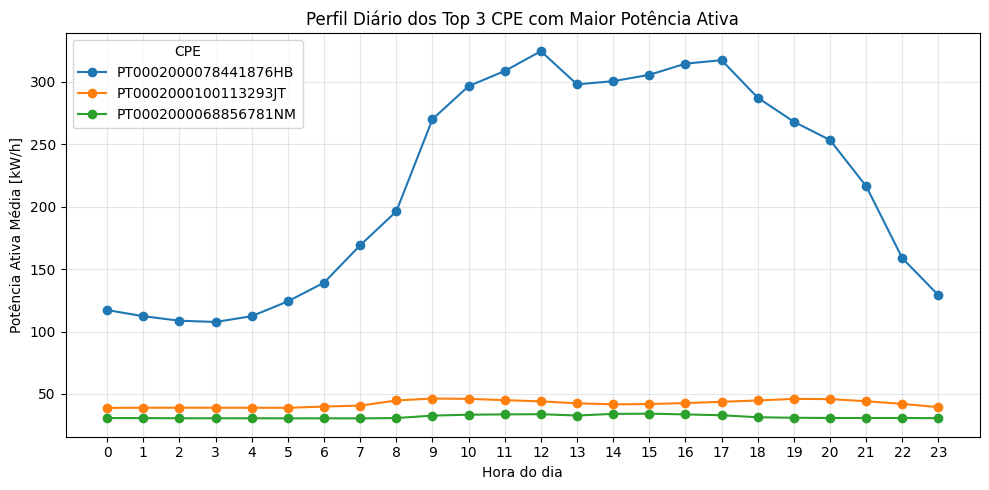

In [19]:
top3 = (
    df.group_by("CPE")
      .agg(pl.col("PotActiva").sum().alias("total"))
      .sort("total", descending=True)
      .head(3)
      .to_pandas()
)

top3_list = top3["CPE"].tolist()
print("Top 3 CPE com maior consumo total:", top3_list)

# Filtrar apenas CPE do Top 3
pdf_top = pdf[pdf["CPE"].isin(top3_list)]

perfis = (
    pdf_top.groupby(["CPE", "hour"])["PotActiva"]
           .mean()
           .reset_index()
)

# Gráfico dos perfis diários
plt.figure(figsize=(10,5))

for cpe in top3_list:
    subset = perfis[perfis["CPE"] == cpe]
    plt.plot(subset["hour"], subset["PotActiva"], marker='o', label=cpe)

plt.title("Perfil Diário dos Top 3 CPE com Maior Potência Ativa")
plt.xlabel("Hora do dia")
plt.ylabel("Potência Ativa Média [kW/h]")
plt.xticks(range(24))
plt.grid(alpha=0.3)
plt.legend(title="CPE")
plt.tight_layout()
plt.show()

# 4. Data Preparation
Nesta fase o objetivo é transformar os dados brutos num formato adequado para análise e modelação. São aplicados procedimentos de limpeza, tratamento de valores em falta, criação de novas features temporais e filtragem de valores anómalos.

As principais tarefas realizadas foram:

- Tratamento de valores ausentes.

- Remoção de registos inválidos (potências negativas, duplicados, etc.).

- Criação de variáveis temporais (hora, dia da semana, mês, ano…).

- Verificação de outliers na potência ativa.

In [20]:
prep_df = df.clone()
prep_df.head(1)

CPE,tstamp,DadosdeConsumo,PotActiva,PotReactIndut,PotReactCapac
str,datetime[μs],f64,f64,f64,f64
"""PT0002000089069203YG""",2022-12-31 00:15:00,null,0.296,null,null


## 4.1 Remove coluna "DadosdeConsumo"

In [21]:
prep_df = prep_df.drop("DadosdeConsumo")
prep_df.head(1)

CPE,tstamp,PotActiva,PotReactIndut,PotReactCapac
str,datetime[μs],f64,f64,f64
"""PT0002000089069203YG""",2022-12-31 00:15:00,0.296,null,null


## 4.2 Remove registos duplicados

In [22]:
antes = prep_df.count().get_column("CPE")[0]
prep_df = prep_df.unique(subset=["CPE", "tstamp"], maintain_order=True)
depois = prep_df.count().get_column("CPE")[0]

print("Registos duplicados removidos:", antes - depois)

Registos duplicados removidos: 1230


## 4.3 Remove registos com potências negativas 

In [23]:
antes = prep_df.count().get_column("CPE")[0]
prep_df = prep_df.filter(pl.col("PotActiva") >= 0)
depois = prep_df.count().get_column("CPE")[0]

print("Registos com potências inválidas removidas:", antes - depois)

Registos com potências inválidas removidas: 0


## 4.4 Remove registos sem valores de potência 

In [24]:
antes = prep_df.count().get_column("CPE")[0]
prep_df = prep_df.filter(~pl.all_horizontal(pl.all().is_null()))
depois = prep_df.count().get_column("CPE")[0]

print("Registos sem potências:", antes - depois)

Registos sem potências: 0


## 4.5 Criar variáveis temporais

In [ ]:
prep_pdf = prep_df.to_pandas()

prep_pdf["hour"] = prep_pdf["tstamp"].dt.hour
prep_pdf["weekday"] = prep_pdf["tstamp"].dt.weekday
prep_pdf["month"] = prep_pdf["tstamp"].dt.month
prep_pdf["year"] = prep_pdf["tstamp"].dt.year

# Período do dia
def periodo(h):
    if 6 <= h < 12: return "morning"
    if 12 <= h < 17: return "afternoon"
    if 17 <= h < 22: return "evening"
    return "night"

prep_pdf["period"] = prep_pdf["hour"].apply(periodo)


# FEATURES POR PERÍODO
period_features = (
    prep_pdf
    .groupby(["CPE", "period"])["PotActiva"]
    .agg(["mean","max","sum"])
    .rename(columns={
        "mean":"mean_power",
        "max":"peak_power",
        "sum":"total_power"
    })
    .unstack(fill_value=0)
)


# FEATURES DIÁRIAS
prep_pdf["date"] = prep_pdf["tstamp"].dt.date

daily = (
    prep_pdf
    .groupby(["CPE","date"])["PotActiva"]
    .agg(["max","mean","std"])
    .rename(columns={
        "max":"daily_peak",
        "mean":"daily_mean",
        "std":"daily_std"
    })
)

# time_below50 
time_below50 = (
    prep_pdf.groupby(["CPE","date"])
    .apply(lambda x: (x["PotActiva"] < x["PotActiva"].mean() * 0.5).sum())
    .reset_index(name="time_below50")
)

# Juntar ao daily corretamente
daily = daily.reset_index().merge(time_below50, on=["CPE","date"]).set_index(["CPE","date"])

#agregações por CPE
daily_features = (
    daily.groupby("CPE").mean()
    .rename(columns={
        "daily_peak":"avg_daily_peak",
        "daily_mean":"avg_daily_mean",
        "daily_std":"avg_daily_std",
        "time_below50":"avg_time_below50"
    })
)


#  PADRÕES SEMANAIS
weekly = (
    prep_pdf.groupby(["CPE","weekday"])["PotActiva"]
    .mean()
    .rename("weekday_mean")
)

weekday_table = weekly.unstack()

weekly_ratio = pd.DataFrame({
    "avg_weekday": weekday_table.loc[:,0:4].mean(axis=1),
    "avg_weekend": weekday_table.loc[:,5:6].mean(axis=1),
})

weekly_ratio["weekend_weekday_ratio"] = (
    weekly_ratio["avg_weekend"] / weekly_ratio["avg_weekday"]
)


# LAG + ROLLING
prep_pdf = prep_pdf.sort_values(["CPE","tstamp"])

lags = (
    prep_pdf.groupby("CPE")["PotActiva"]
    .apply(lambda x: pd.DataFrame({
        "lag_1day": x.shift(96),
        "lag_1week": x.shift(96*7),
        "roll_1day": x.rolling(96).mean(),
        "roll_1week": x.rolling(96*7).mean(),
    }))
)


# remover níveis do MultiIndex
period_features.columns = [
    f"{metric}_{period}"
    for metric, period in period_features.columns
]

# garantir que o index é só "CPE"
period_features = period_features.reset_index().set_index("CPE")



# JUNTAR TODAS AS FEATURES
features_final = (
      daily_features
    .join(period_features, how="left")
    .join(weekly_ratio, how="left")
)

print(features_final.head())

C:\Users\migue\AppData\Local\Temp\ipykernel_25364\2271230552.py:51: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["PotActiva"] < x["PotActiva"].mean() * 0.5).sum())


                      avg_daily_peak  avg_daily_mean  avg_daily_std  \
CPE                                                                   
PT0002000032936306KX        5.334452        2.451701       2.546508   
PT0002000032942455NH        0.257027        0.090997       0.054953   
PT0002000032959511HP        0.000000        0.000000       0.000000   
PT0002000032966446CC        0.322175        0.099622       0.066023   
PT0002000032968749YT       11.542965        3.636439       2.627443   

                      avg_time_below50  mean_power_afternoon  \
CPE                                                            
PT0002000032936306KX         47.155779              0.004103   
PT0002000032942455NH         20.579104              0.097075   
PT0002000032959511HP          0.000000              0.000000   
PT0002000032966446CC         22.942623              0.098169   
PT0002000032968749YT         23.951754              5.214901   

                      mean_power_evening  mean_power_

# Dicionário de Features 

## 1. Métricas Diárias
- **avg_daily_peak** — Pico diário médio da Potência Ativa.  
- **avg_daily_mean** — Consumo médio diário típico.  
- **avg_daily_std** — Variabilidade média diária.  
- **avg_time_below50** — Nº médio de registos/dia abaixo de 50% do consumo diário.


## 2. Métricas por Período do Dia  
Períodos:  
**morning (06–12)** · **afternoon (12–17)** · **evening (17–22)** · **night (22–06)**  

Para cada período existem 3 features:

- **mean_power_<period>** — Consumo médio.  
- **peak_power_<period>** — Pico máximo.  
- **total_power_<period>** — Consumo acumulado.

*Ex.: `mean_power_afternoon`, `peak_power_evening`, `total_power_night`*


## 3. Padrões Semanais
- **avg_weekday** — Consumo médio de 2ª a 6ª.  
- **avg_weekend** — Consumo médio ao fim de semana.  
- **weekend_weekday_ratio** — Relação fim de semana / dias úteis.


## 4. Lag & Rolling (Séries Temporais)
- **lag_1day** — Valor de Potência Ativa de 1 dia antes (96 amostras).  
- **lag_1week** — Valor de 1 semana antes (96×7 amostras).  
- **roll_1day** — Média móvel de 1 dia (suaviza ruído diário).  
- **roll_1week** — Média móvel de 1 semana (suaviza padrões semanais).




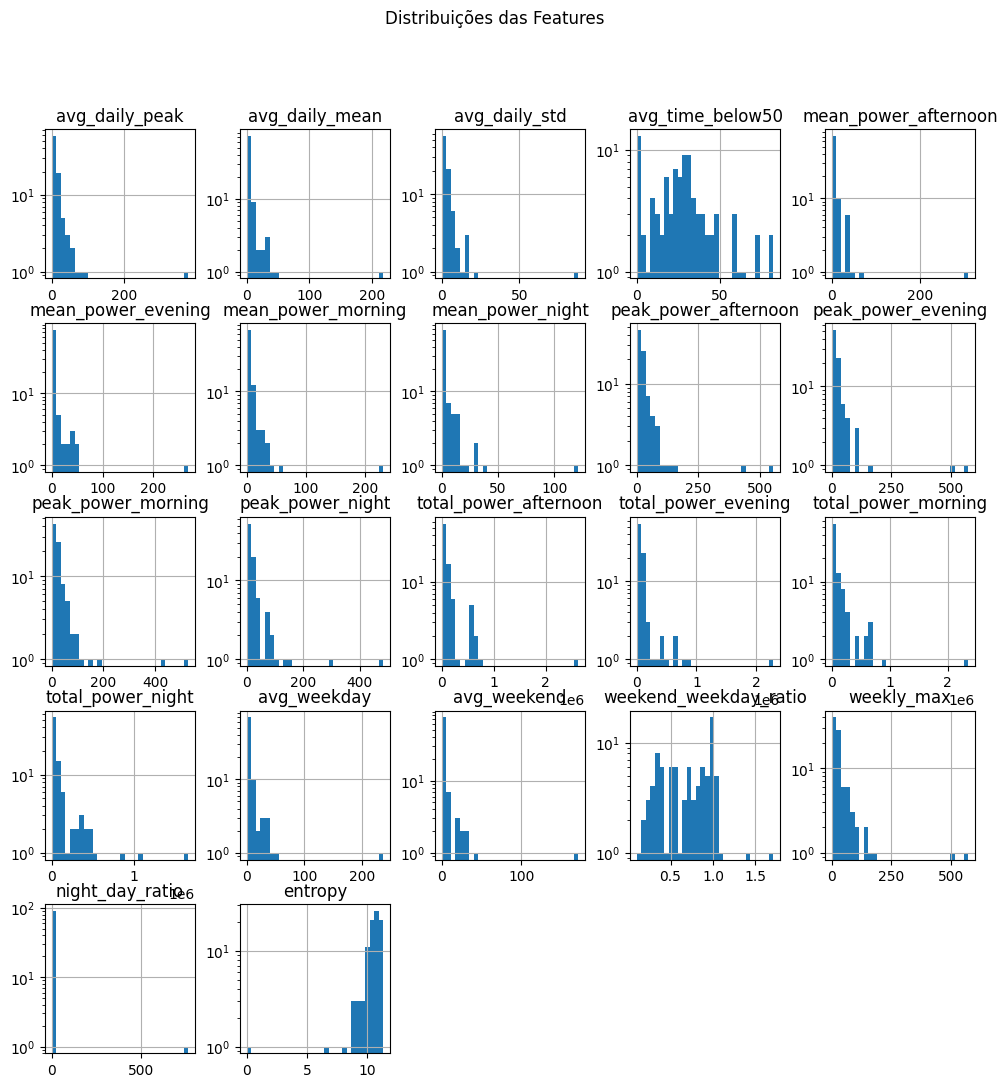

In [56]:
feat = features_final.copy()
feat = feat.reset_index()

feat.select_dtypes(include=["float","int"]).hist(
    figsize=(12,12), bins=30, log=True
)
plt.suptitle("Distribuições das Features")
plt.show()

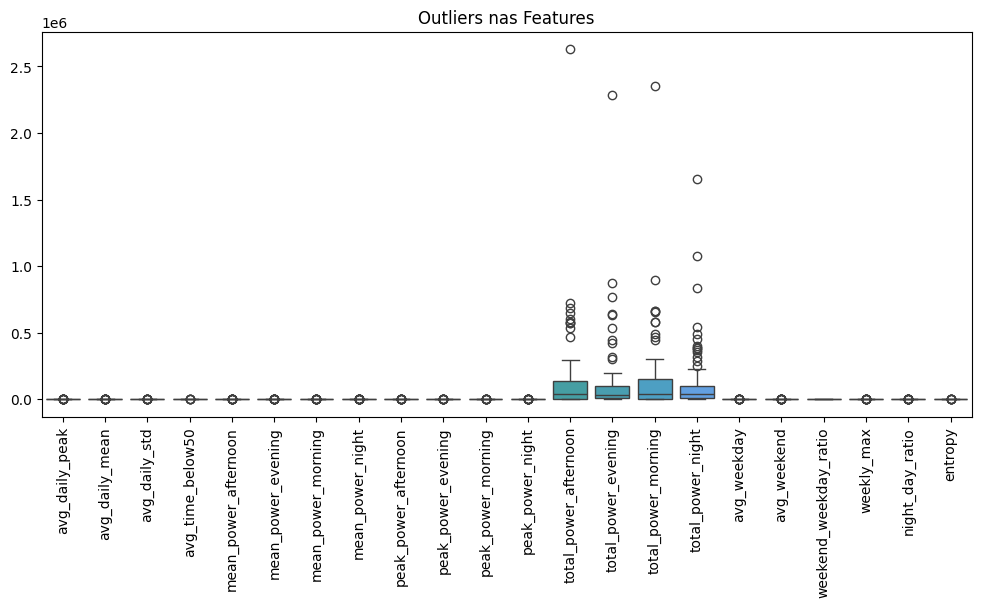

In [53]:
plt.figure(figsize=(12,5))
sns.boxplot(data=feat.select_dtypes(include=["float","int"]))
plt.xticks(rotation=90)
plt.title("Outliers nas Features")
plt.show()

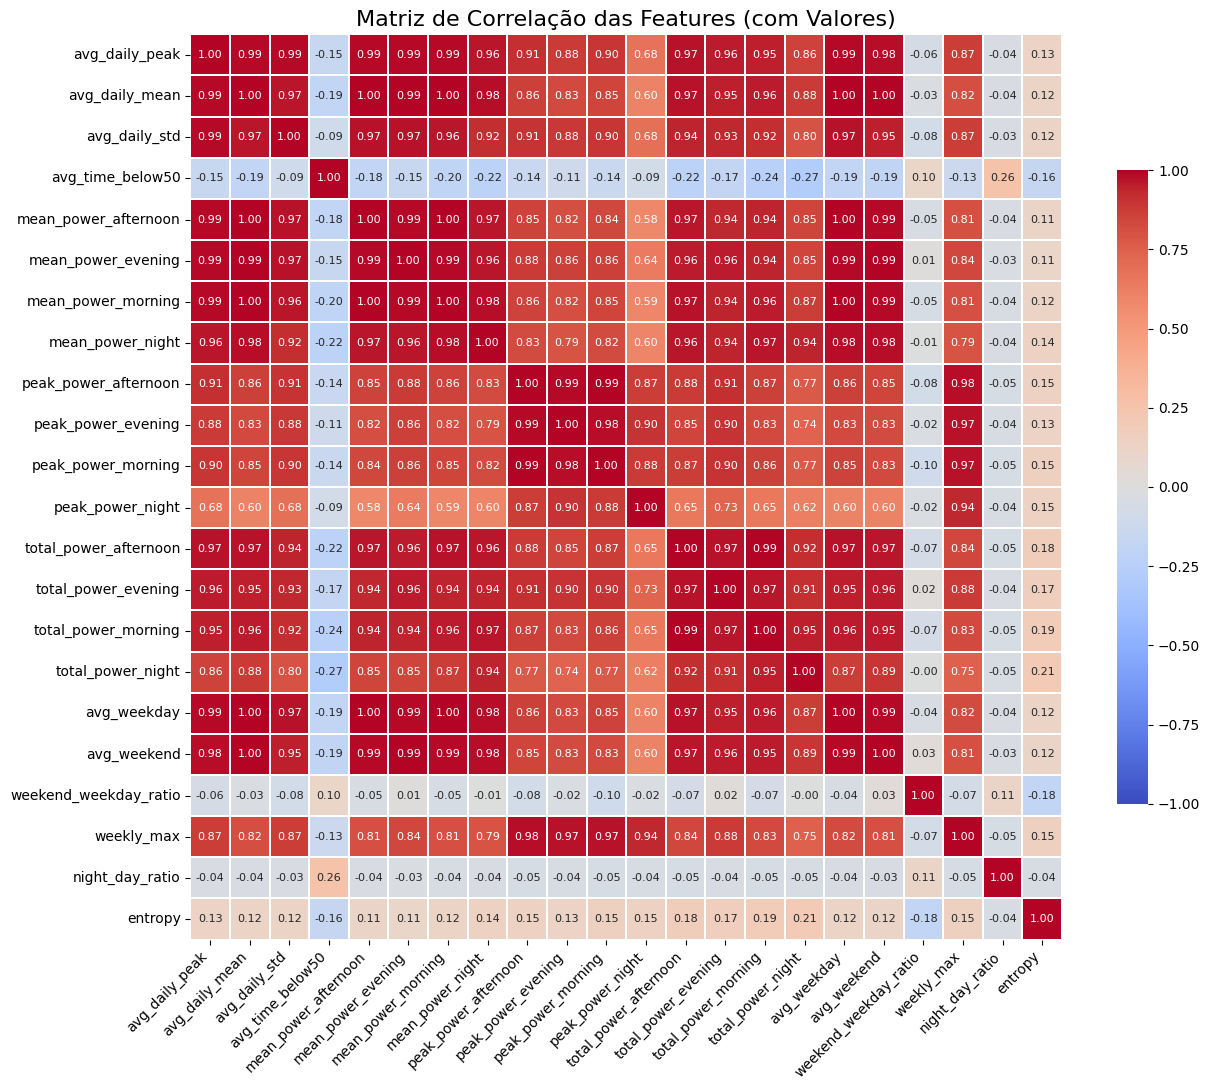

In [ ]:
feat_num = feat.select_dtypes(include=["float", "int"])

plt.figure(figsize=(13,11))

sns.heatmap(
    feat_num.corr(),
    cmap="coolwarm",
    annot=True,           
    fmt=".2f",             
    annot_kws={"size": 8}, 
    linewidths=0.3,
    cbar_kws={"shrink": 0.7},
    vmin=-1.0,
    vmax=1.0
)

plt.title("Matriz de Correlação das Features (com Valores)", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [29]:
corr_target = feat_num.corr()["avg_daily_mean"].sort_values(ascending=False)
corr_target

avg_daily_mean           1.000000
avg_weekday              0.999576
mean_power_morning       0.998271
mean_power_afternoon     0.996872
avg_weekend              0.995041
mean_power_evening       0.992918
avg_daily_peak           0.989876
mean_power_night         0.981573
total_power_afternoon    0.972021
avg_daily_std            0.967591
total_power_morning      0.958014
total_power_evening      0.951002
total_power_night        0.879176
peak_power_afternoon     0.861216
peak_power_morning       0.849349
peak_power_evening       0.829750
peak_power_night         0.604678
weekend_weekday_ratio   -0.025510
avg_time_below50        -0.186883
Name: avg_daily_mean, dtype: float64

In [30]:
corr = feat_num.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), 1).astype(bool))

redundantes = [col for col in upper.columns if any(upper[col] > 0.95)]
redundantes

['avg_daily_mean',
 'avg_daily_std',
 'mean_power_afternoon',
 'mean_power_evening',
 'mean_power_morning',
 'mean_power_night',
 'peak_power_evening',
 'peak_power_morning',
 'total_power_afternoon',
 'total_power_evening',
 'total_power_morning',
 'total_power_night',
 'avg_weekday',
 'avg_weekend']

In [ ]:
# weekly_max
weekly_max = (
    prep_pdf.groupby("CPE")["PotActiva"]
    .max()
    .rename("weekly_max")
)


#  night_day_ratio
prep_pdf["period"] = prep_pdf["hour"].apply(periodo)

# Consumo total por CPE em cada período
period_totals = (
    prep_pdf.groupby(["CPE", "period"])["PotActiva"]
    .sum()
    .unstack(fill_value=0)
)

# Criar rácio noite/dia
period_totals["night_day_ratio"] = (
    period_totals["night"] / (period_totals["morning"] + period_totals["afternoon"] + 1e-6)
)

night_day_ratio = period_totals["night_day_ratio"]


#  entropy (entropia da distribuição de consumo)
def calc_entropy(series):
    # Normalizar valores de potência para probabilidades
    p = series.values
    p = p[p > 0]              # remover zeros porque destroem log
    if len(p) == 0:
        return 0.0
    p = p / p.sum()
    return entropy(p)         # entropia de Shannon

entropy_feature = (
    prep_pdf.groupby("CPE")["PotActiva"]
    .apply(calc_entropy)
    .rename("entropy")
)


# juntar tudo ao conjunto final de features existente
features_final = (
    features_final
    .join(weekly_max, how="left")
    .join(night_day_ratio, how="left")
    .join(entropy_feature, how="left")
)

print(features_final.head())

                      avg_daily_peak  avg_daily_mean  avg_daily_std  \
CPE                                                                   
PT0002000032936306KX        5.334452        2.451701       2.546508   
PT0002000032942455NH        0.257027        0.090997       0.054953   
PT0002000032959511HP        0.000000        0.000000       0.000000   
PT0002000032966446CC        0.322175        0.099622       0.066023   
PT0002000032968749YT       11.542965        3.636439       2.627443   

                      avg_time_below50  mean_power_afternoon  \
CPE                                                            
PT0002000032936306KX         47.155779              0.004103   
PT0002000032942455NH         20.579104              0.097075   
PT0002000032959511HP          0.000000              0.000000   
PT0002000032966446CC         22.942623              0.098169   
PT0002000032968749YT         23.951754              5.214901   

                      mean_power_evening  mean_power_

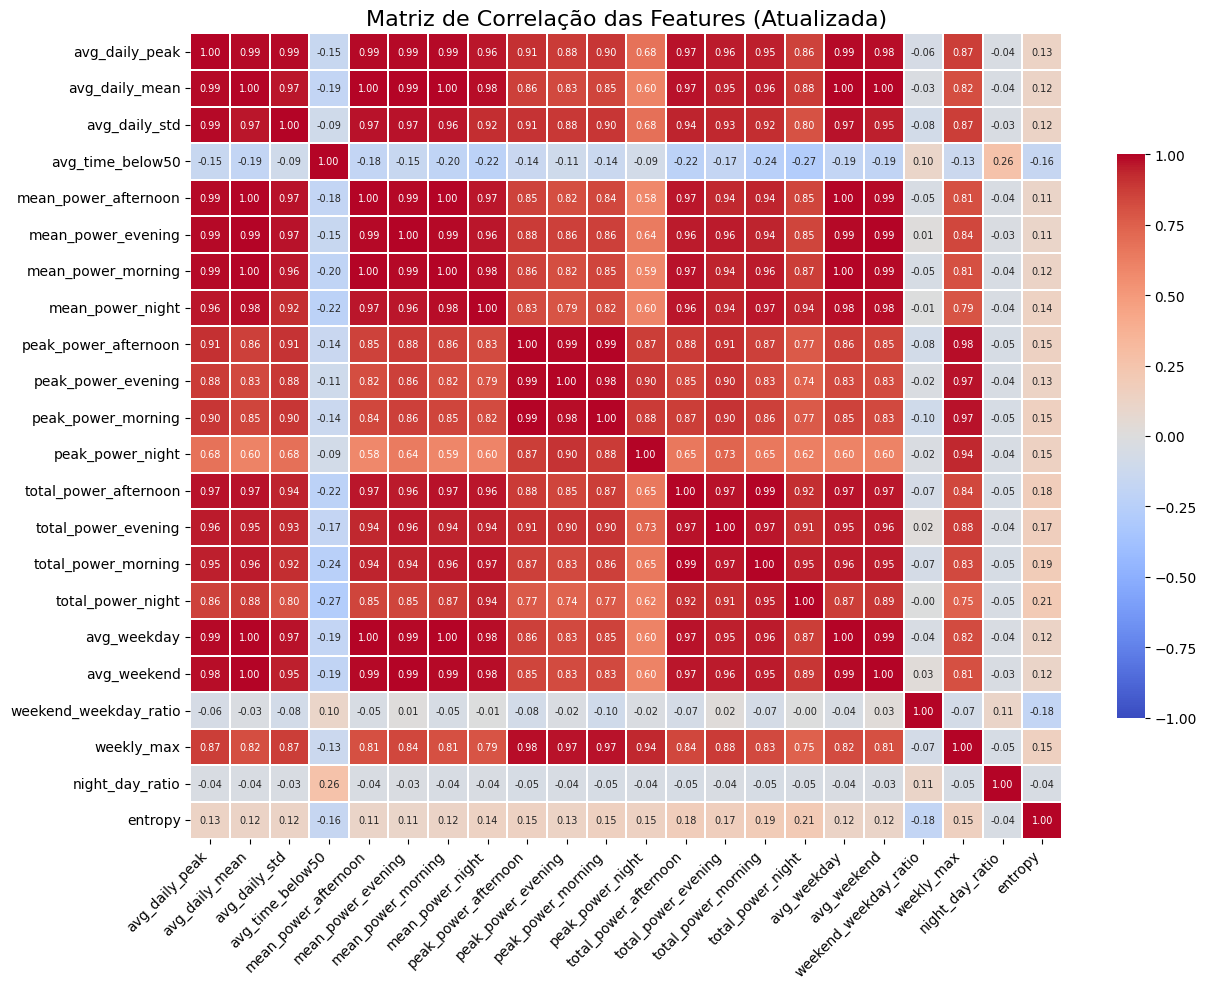

In [67]:
featupdated = features_final.copy().reset_index()

feat_num_updated = featupdated.select_dtypes(include=["float", "int"])

plt.figure(figsize=(13,10))

sns.heatmap(
    feat_num_updated.corr(),
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    annot_kws={"size": 7},
    linewidths=0.3,
    cbar_kws={"shrink": 0.7},
    vmin=-1.0,
    vmax=1.0
)

plt.title("Matriz de Correlação das Features (Atualizada)", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [33]:
features_raw = features_final.copy()
feat_num = features_raw.select_dtypes(include=["float", "int"])
corr = feat_num.corr().abs()

upper = corr.where(np.triu(np.ones(corr.shape), 1).astype(bool))

to_drop = [
    column 
    for column in upper.columns 
    if any(upper[column] > 0.95)
]

# Manter apenas features que não estão na lista to_drop
features_clean = features_raw.drop(columns=to_drop)

print("Removidas:", to_drop)
print("Total antes:", features_raw.shape[1])
print("Total depois:", features_clean.shape[1])

Removidas: ['avg_daily_mean', 'avg_daily_std', 'mean_power_afternoon', 'mean_power_evening', 'mean_power_morning', 'mean_power_night', 'peak_power_evening', 'peak_power_morning', 'total_power_afternoon', 'total_power_evening', 'total_power_morning', 'total_power_night', 'avg_weekday', 'avg_weekend', 'weekly_max']
Total antes: 22
Total depois: 7


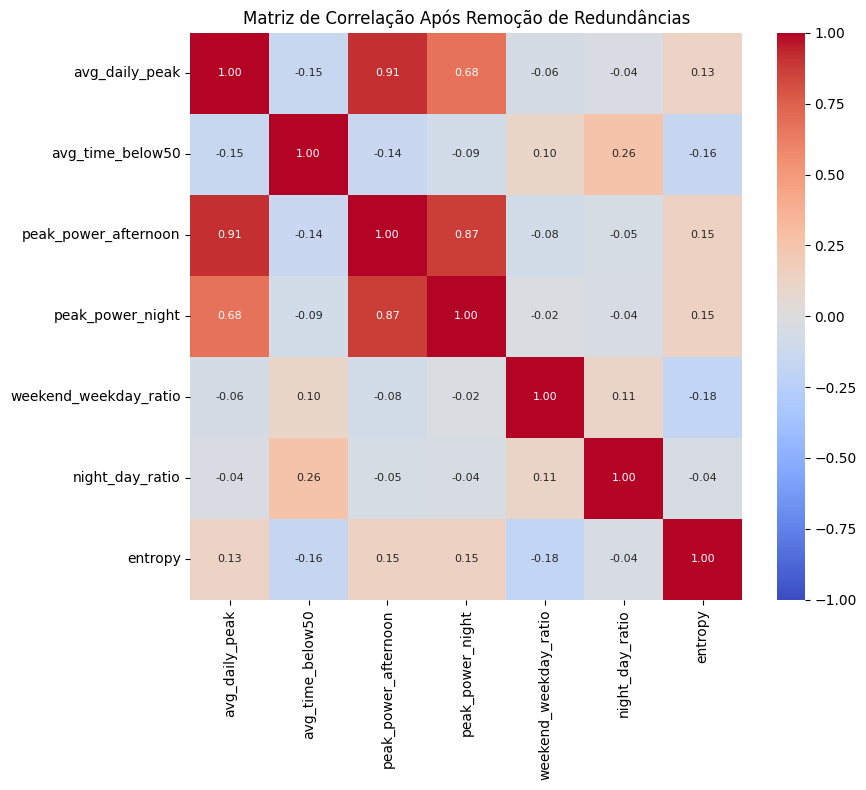

In [70]:
feat_num_clean = features_clean.select_dtypes(include=["float", "int"])

plt.figure(figsize=(9,8))
sns.heatmap(
    feat_num_clean.corr(),
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    annot_kws={"size":8},
    vmin=-1.0,
    vmax=1.0
)
plt.title("Matriz de Correlação Após Remoção de Redundâncias")
plt.tight_layout()
plt.show()

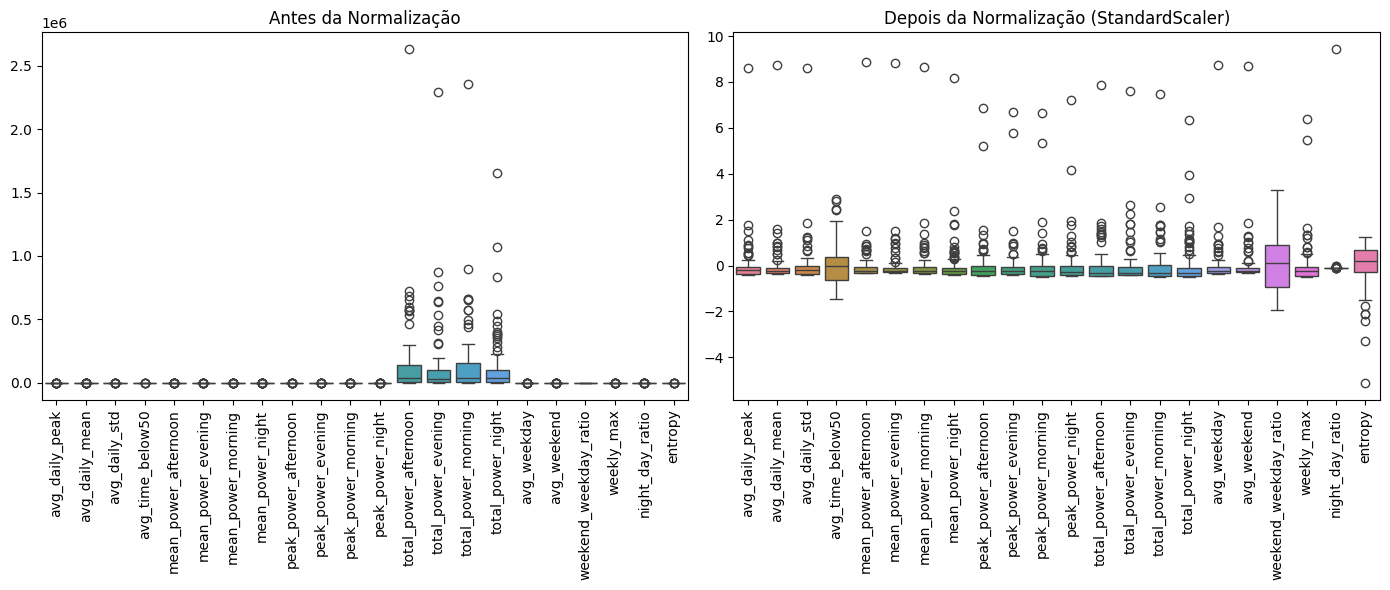

In [35]:
# Selecionar apenas features numéricas
feat = features_final.copy()
feat_num = feat.select_dtypes(include=["float", "int"])

# Remover linhas com NaN (necessário para o PCA)
feat_pca = feat_num.dropna()

# Normalização correta
scaler = StandardScaler()
feat_scaled = pd.DataFrame(
    scaler.fit_transform(feat_pca),
    index=feat_pca.index,
    columns=feat_pca.columns
)

# BOX-PLOT ANTES E DEPOIS

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.boxplot(data=feat_pca)
plt.title("Antes da Normalização")
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.boxplot(data=feat_scaled)
plt.title("Depois da Normalização (StandardScaler)")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

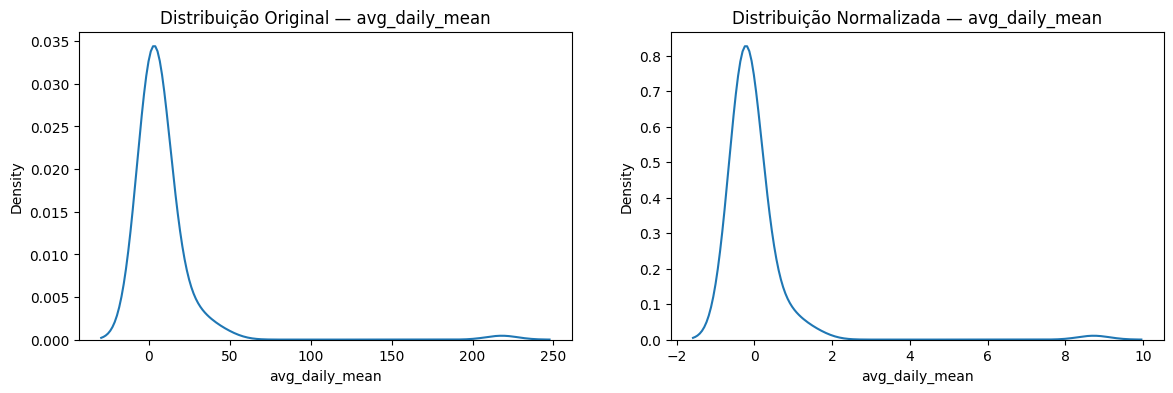

In [36]:
# distribuições antes e depois da normalização do avg_daily_mean

fig, ax = plt.subplots(1, 2, figsize=(14,4))

sns.kdeplot(feat_pca["avg_daily_mean"], ax=ax[0])
sns.kdeplot(feat_scaled["avg_daily_mean"], ax=ax[1])

ax[0].set_title("Distribuição Original — avg_daily_mean")
ax[1].set_title("Distribuição Normalizada — avg_daily_mean")

plt.show()

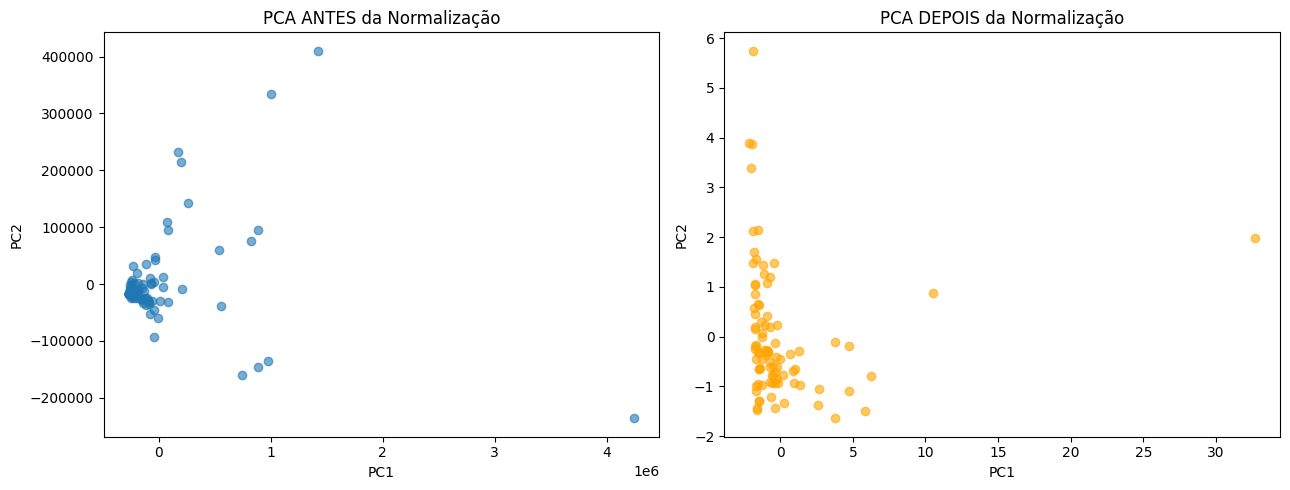

In [37]:
# PCA ANTES E DEPOIS 

pca1 = PCA(n_components=2)
pca_before = pca1.fit_transform(feat_pca)

pca2 = PCA(n_components=2)
pca_after  = pca2.fit_transform(feat_scaled)

plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.scatter(pca_before[:,0], pca_before[:,1], alpha=0.6)
plt.title("PCA ANTES da Normalização")
plt.xlabel("PC1"); plt.ylabel("PC2")

plt.subplot(1,2,2)
plt.scatter(pca_after[:,0], pca_after[:,1], alpha=0.6, color="orange")
plt.title("PCA DEPOIS da Normalização")
plt.xlabel("PC1"); plt.ylabel("PC2")

plt.tight_layout()
plt.show()

In [38]:
feat_num = features_final.select_dtypes(include=["float","int"])

# Remover NaN
feat_clust = feat_num.dropna()

# Normalizar
scaler = StandardScaler()
feat_scaled = scaler.fit_transform(feat_clust)

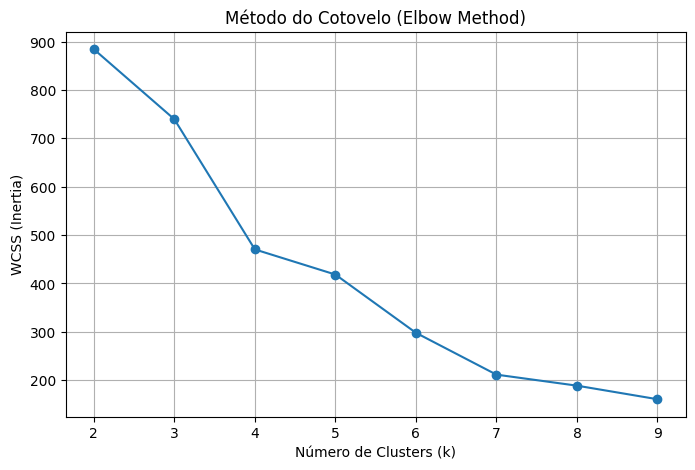

In [39]:
wcss = []  # Within-cluster sum of squares

K = range(2, 10)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(feat_scaled)
    wcss.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, wcss, marker='o')
plt.xlabel("Número de Clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.title("Método do Cotovelo (Elbow Method)")
plt.grid(True)
plt.show()


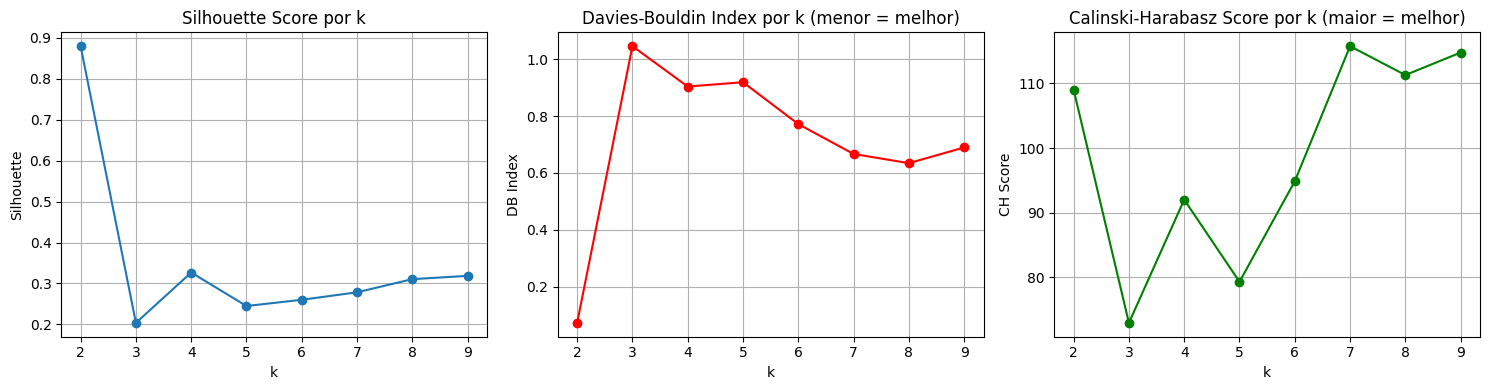

{'Silhouette': {2: 0.8800134521309512,
  3: 0.2035192536598731,
  4: 0.3266660474083507,
  5: 0.24475392297712917,
  6: 0.26000147474232416,
  7: 0.27829742006744385,
  8: 0.310433751658004,
  9: 0.3184689260755828},
 'Davies-Bouldin': {2: 0.07356765274420678,
  3: 1.0453623485287071,
  4: 0.9035376393025858,
  5: 0.9187755901381681,
  6: 0.771742658572201,
  7: 0.666864610380191,
  8: 0.6345364459791563,
  9: 0.6895552582716701},
 'Calinski-Harabasz': {2: 109.04292694843127,
  3: 72.9792474722642,
  4: 92.02759895351768,
  5: 79.3315049752775,
  6: 94.880550594481,
  7: 115.76208557828714,
  8: 111.29789980085201,
  9: 114.775893398959}}

In [40]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

sil_scores = {}
dbi_scores = {}
chi_scores = {}

for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(feat_scaled)

    # Silhouette
    sil_scores[k] = silhouette_score(feat_scaled, labels)

    # Davies-Bouldin (menor = melhor)
    dbi_scores[k] = davies_bouldin_score(feat_scaled, labels)

    # Calinski-Harabasz (maior = melhor)
    chi_scores[k] = calinski_harabasz_score(feat_scaled, labels)



plt.figure(figsize=(15,4))

# Silhouette
plt.subplot(1,3,1)
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o')
plt.title("Silhouette Score por k")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.grid(True)

# Davies–Bouldin
plt.subplot(1,3,2)
plt.plot(list(dbi_scores.keys()), list(dbi_scores.values()), marker='o', color='red')
plt.title("Davies-Bouldin Index por k (menor = melhor)")
plt.xlabel("k")
plt.ylabel("DB Index")
plt.grid(True)

# Calinski-Harabasz
plt.subplot(1,3,3)
plt.plot(list(chi_scores.keys()), list(chi_scores.values()), marker='o', color='green')
plt.title("Calinski-Harabasz Score por k (maior = melhor)")
plt.xlabel("k")
plt.ylabel("CH Score")
plt.grid(True)

plt.tight_layout()
plt.show()

# Mostrar valores numéricos
{"Silhouette": sil_scores, "Davies-Bouldin": dbi_scores, "Calinski-Harabasz": chi_scores}


In [41]:
best_k = 8

kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(feat_scaled)

feat_clust["cluster"] = cluster_labels

C:\Users\migue\AppData\Local\Temp\ipykernel_25364\379619448.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feat_clust["cluster"] = cluster_labels


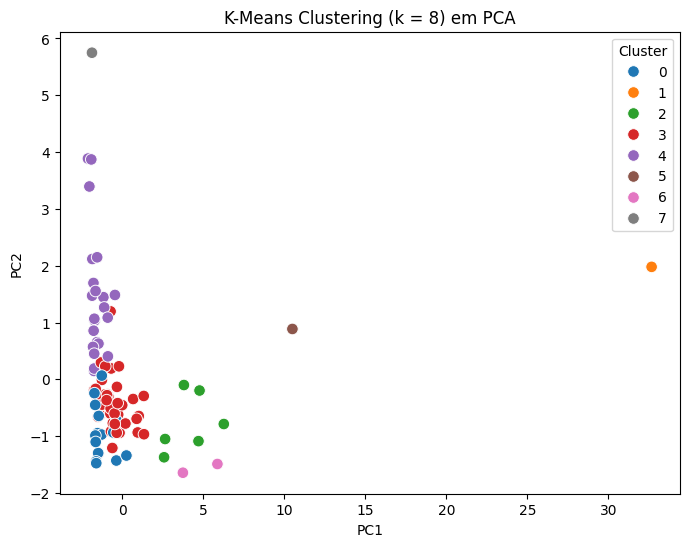

In [42]:
pca = PCA(n_components=2)
coords = pca.fit_transform(feat_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=coords[:,0], y=coords[:,1],
    hue=cluster_labels,
    palette='tab10',
    s=70
)

plt.title(f"K-Means Clustering (k = {best_k}) em PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()


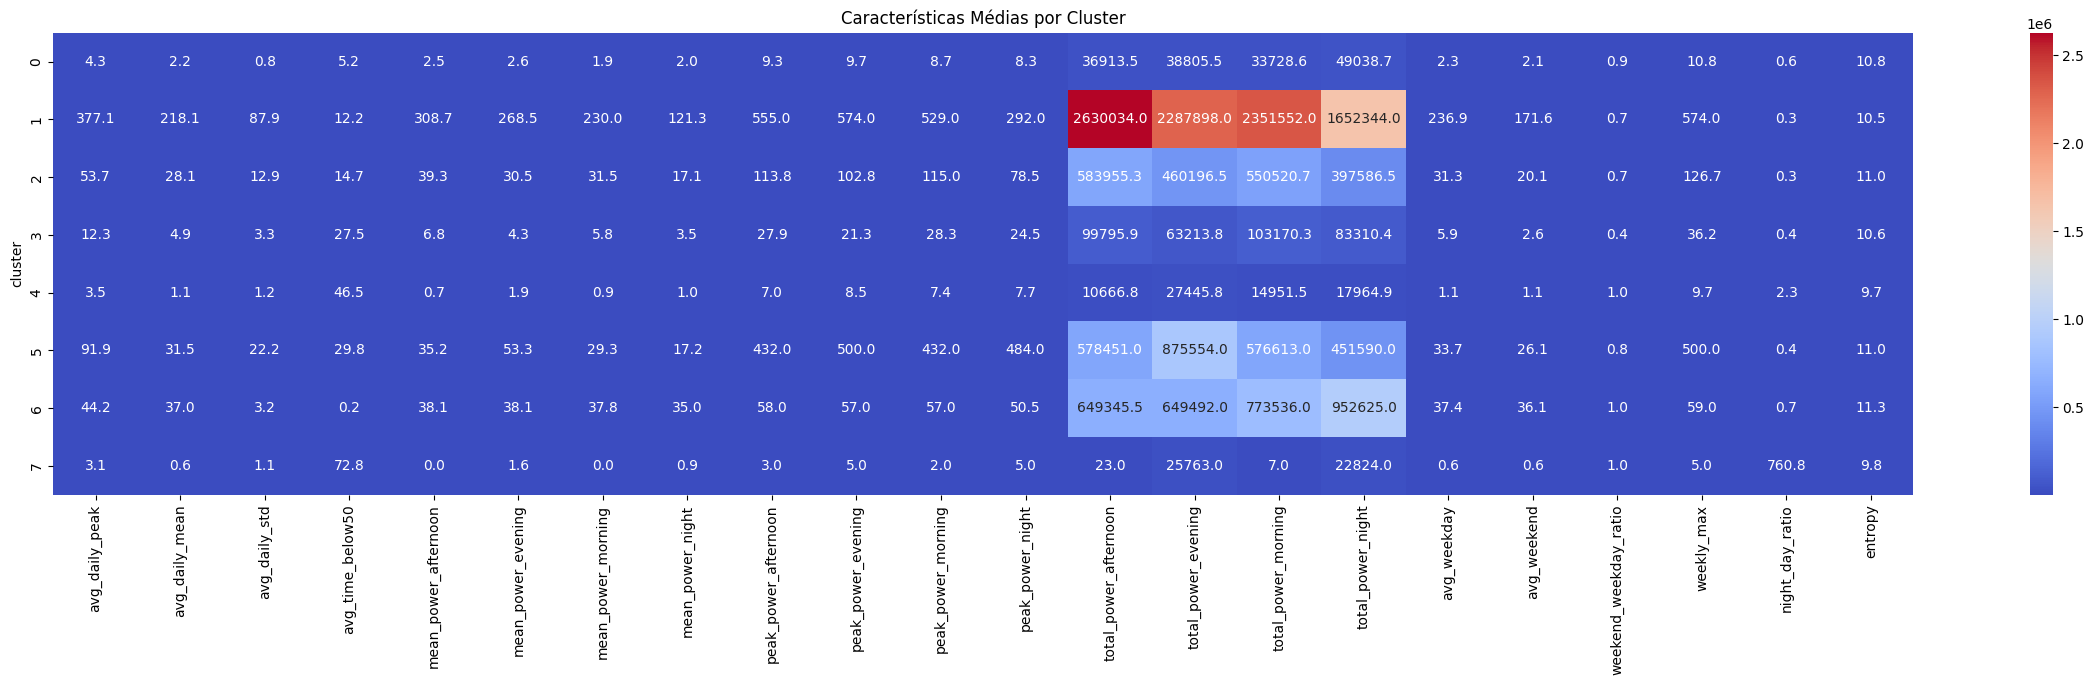

In [43]:
cluster_summary = feat_clust.groupby("cluster").mean()
cluster_summary

plt.figure(figsize=(30,6))
sns.heatmap(cluster_summary, cmap="coolwarm", annot=True, fmt=".1f")
plt.title("Características Médias por Cluster")
plt.show()


In [44]:
cluster_sizes = feat_clust["cluster"].value_counts().sort_index()

summary_for_report = pd.DataFrame({
    "N_CPE": cluster_sizes,
    "avg_daily_mean": cluster_summary["avg_daily_mean"],
    "weekly_max": cluster_summary["weekly_max"],
    "total_power": (
        cluster_summary["total_power_morning"] +
        cluster_summary["total_power_afternoon"] +
        cluster_summary["total_power_evening"] +
        cluster_summary["total_power_night"]
    ),
    "weekend_weekday_ratio": cluster_summary["weekend_weekday_ratio"],
    "night_day_ratio": cluster_summary["night_day_ratio"],
})
summary_for_report


,N_CPE,avg_daily_mean,weekly_max,total_power,weekend_weekday_ratio,night_day_ratio
cluster,,,,,,
0,15,2.230791,10.764267,1.584863e+05,0.947921,0.609664
1,1,218.081217,574.000000,8.921828e+06,0.724585,0.331690
2,6,28.107458,126.666667,1.992259e+06,0.660825,0.349965
3,42,4.931437,36.207714,3.494904e+05,0.443342,0.417984
4,22,1.090393,9.720364,7.102906e+04,0.992258,2.332616
5,1,31.506593,500.000000,2.482208e+06,0.773712,0.390965
6,2,36.961995,59.000000,3.024998e+06,0.963428,0.670782
7,1,0.617511,5.000000,4.861700e+04,1.015515,760.799975


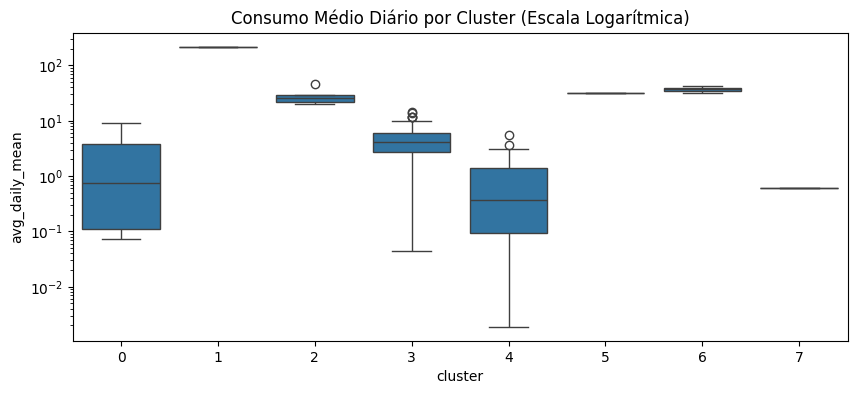

In [71]:
plt.figure(figsize=(10,4))
sns.boxplot(data=feat_clust, x="cluster", y="avg_daily_mean")
plt.yscale("log")
plt.title("Consumo Médio Diário por Cluster (Escala Logarítmica)")
plt.show()

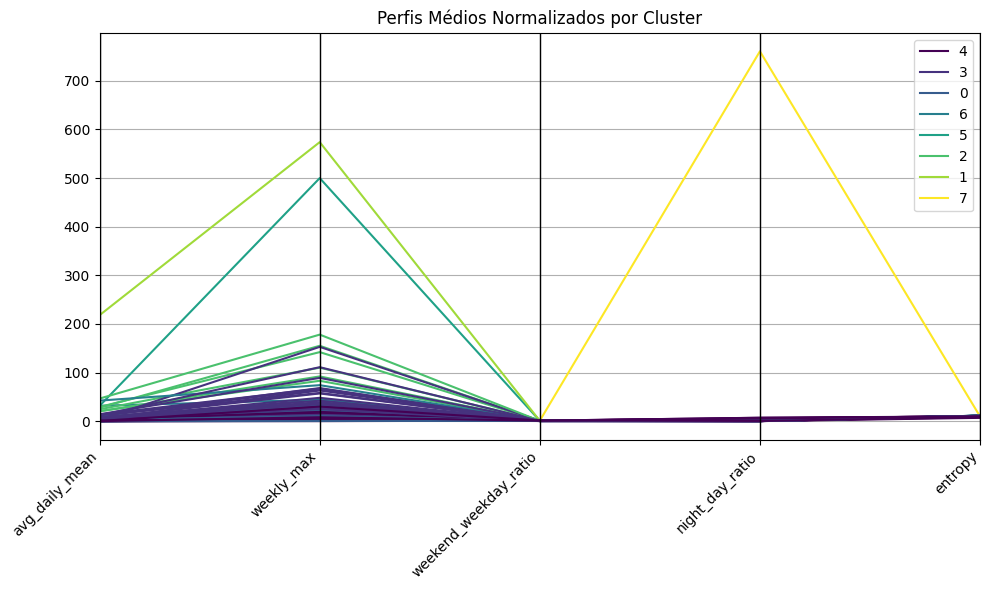

In [72]:
from pandas.plotting import parallel_coordinates

# 1) Copiar o dataframe com clusters
df_plot = feat_clust.copy()          # feat_clust é o teu dataframe com as features + "cluster"

# 2) Se houver índice (CPE), trazer para coluna normal
df_plot = df_plot.reset_index()      # se o CPE estiver no índice

# 3) Garantir que TODOS os nomes de colunas são strings
df_plot.columns = df_plot.columns.map(str)

# 4) Garantir que "cluster" é string (classe categórica)
df_plot["cluster"] = df_plot["cluster"].astype(str)

# 5) (Opcional) escolher apenas algumas features para não ficar caótico
cols_features = [
    "avg_daily_mean",
    "weekly_max",
    "weekend_weekday_ratio",
    "night_day_ratio",
    "entropy",
]

# Construir dataframe final para o gráfico: classe + features
df_pc = df_plot[["cluster"] + cols_features]

# 6) Parallel coordinates
plt.figure(figsize=(10, 6))
parallel_coordinates(
    df_pc,
    class_column="cluster",
    colormap="viridis"
)
plt.xticks(rotation=45, ha="right")
plt.title("Perfis Médios Normalizados por Cluster")
plt.tight_layout()
plt.show()


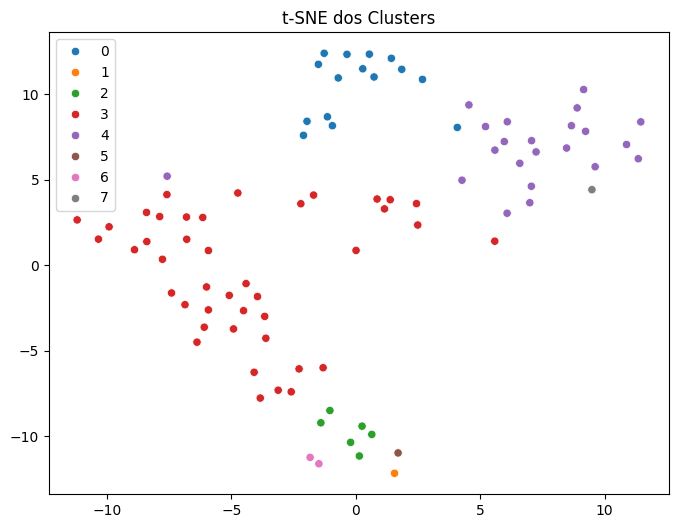

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=15, random_state=42)
coords_tsne = tsne.fit_transform(feat_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=coords_tsne[:,0], y=coords_tsne[:,1],
    hue=cluster_labels, palette="tab10"
)
plt.title("t-SNE dos Clusters")
plt.show()

O PCA permite representar os dados num espaço de 2 dimensões maximizando a variância, mas não preserva relações de proximidade entre os pontos.
Por isso, pode distorcer a estrutura real dos clusters.

Para avaliar se os clusters encontrados são realmente separados no espaço original, é preferível usar métodos não lineares como o t-SNE, que preservam vizinhanças e evidenciam agrupamentos naturais.